In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import numpy as np
from decimal import Decimal

## FDM for Parabolic Equations
Using second order central difference for u_xx

In [2]:
def sli_with_spatial_terms_model(t, y, b, d, B, Y, a, e):
    """
    Parameters
    ----------
    b: Birth rate
    d: Natural death rate
    B: Infection rate
    Y: Parameter to take into account density dependent reduction in population
    a: Death rate due to infection
    e: Rate of individuals that turn infective
    """
    global ENABLE_SPATIAL_DOMAIN_TERMS
    global size_x, matrix_factor

    S, L, I = y[:size_x], y[size_x:2*size_x], y[2*size_x:]
    N = S + L + I

    dS_dt = b * N - d * S - Y * S * N - B * S * I
    dL_dt = B * S * I - d * L - Y * L * N - e * L
    dI_dt = e * L - Y * I * N - a * I - d * I
    
    if ENABLE_SPATIAL_DOMAIN_TERMS:
        dS_dt += matrix_factor.dot(S)
        dL_dt += matrix_factor.dot(L)
        dI_dt += matrix_factor.dot(I)
    
    return np.concatenate([dS_dt, dL_dt, dI_dt])

In [3]:
def plot_results(sol, x, size_x, max_t):
    plot_every = 1 #year
    fig, ax = plt.subplots(2,2, figsize=(15,10))

    S, L, I = sol.y[:size_x,:], sol.y[size_x:2*size_x,:], sol.y[2*size_x:,:]

    sns.lineplot(x=sol.t[:], y=S[0, :], label="Susceptible", ax=ax[0, 0], color=[0, 1, 0])
    sns.lineplot(x=sol.t[:], y=L[0, :], label="Latent", ax=ax[0, 0], color=[0, 0, 1])
    sns.lineplot(x=sol.t[:], y=I[0, :], label="Infectious", ax=ax[0, 0], color=[1, 0, 0])

    for year in range(max_t + 1):
        t_div_idx = int(year * (sol.t.size - 1) / (max_t))
        sns.lineplot(x=x, y=S[:, t_div_idx],
            color=[0, np.linspace(1, 0, max_t + 1)[year], 0],
            label=f"t = {year} years",
            ax=ax[0, 1])
        sns.lineplot(x=x, y=L[:, t_div_idx],
            color=[0, 0, np.linspace(1, 0, max_t + 1)[year]],
            label=f"t = {year} years",
            ax=ax[1, 0])
        sns.lineplot(x=x, y=I[:, t_div_idx],
            color=[np.linspace(1, 0, max_t + 1)[year], 0, 0],
            label=f"t = {year} years",
            ax=ax[1, 1])
    
    ax[0, 0].grid(True)
    ax[0, 0].set_title("Evolution at distance=0km")
    ax[0, 0].set_xlabel("Time [years]")
    ax[0, 0].set_ylabel("Number of salamanders")
    ax[0, 1].set_title("Susceptible")
    ax[0, 1].set_xlabel("Distance [km]")
    ax[0, 1].set_ylabel("Number of salamanders")
    ax[1, 0].set_title("Latent")
    ax[1, 0].set_xlabel("Distance [km]")
    ax[1, 0].set_ylabel("Number of salamanders")
    ax[1, 1].set_title("Infectious")
    ax[1, 1].set_xlabel("Distance [km]")
    ax[1, 1].set_ylabel("Number of salamanders")
    plt.show()

In [4]:
def save_plots(sol, x, size_x, max_t, suffix):

    S, L, I = sol.y[:size_x,:], sol.y[size_x:2*size_x,:], sol.y[2*size_x:,:]

    plt.figure(figsize=(8,4))
    sns.lineplot(x=sol.t[:], y=S[0, :], label="Susceptible", color=[0, 1, 0])
    sns.lineplot(x=sol.t[:], y=L[0, :], label="Latent", color=[0, 0, 1])
    sns.lineplot(x=sol.t[:], y=I[0, :], label="Infectious", color=[1, 0, 0])
    plt.grid(True)
    plt.title("Evolution at distance=0km", fontsize=16)
    plt.xlabel("Time [years]", fontsize=16)
    plt.ylabel("Number of salamanders", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12, title="Population", title_fontsize=12)
    plt.savefig(f"plots_presentation/diffused_sli_overview{suffix}.svg", format='svg', bbox_inches="tight", pad_inches=0)

    plt.figure(figsize=(8,4.5))
    for year in range(max_t + 1):
        t_div_idx = int(year * (sol.t.size - 1) / (max_t))
        sns.lineplot(x=x, y=S[:, t_div_idx],
            color=[0, np.linspace(1, 0, max_t + 1)[year], 0],
            label=f"t = {year} years")
    plt.title("Susceptible", fontsize=16)
    plt.xlabel("Distance [km]", fontsize=16)
    plt.ylabel("Number of salamanders", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14, loc='upper right')
    plt.savefig(f"plots_presentation/diffused_sli_S{suffix}.svg", format='svg', bbox_inches="tight", pad_inches=0)

    plt.figure(figsize=(8,4.5))
    for year in range(max_t + 1):
        t_div_idx = int(year * (sol.t.size - 1) / (max_t))
        sns.lineplot(x=x, y=L[:, t_div_idx],
            color=[0, 0, np.linspace(1, 0, max_t + 1)[year]],
            label=f"t = {year} years")
    plt.title("Latent", fontsize=16)
    plt.xlabel("Distance [km]", fontsize=16)
    plt.ylabel("Number of salamanders", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14, loc='upper right')
    plt.savefig(f"plots_presentation/diffused_sli_L{suffix}.svg", format='svg', bbox_inches="tight", pad_inches=0)

    plt.figure(figsize=(8,4.5))
    for year in range(max_t + 1):
        t_div_idx = int(year * (sol.t.size - 1) / (max_t))
        sns.lineplot(x=x, y=I[:, t_div_idx],
            color=[np.linspace(1, 0, max_t + 1)[year], 0, 0],
            label=f"t = {year} years")
    plt.title("Infectious", fontsize=16)
    plt.xlabel("Distance [km]", fontsize=16)
    plt.ylabel("Number of salamanders", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14, loc='upper right')
    plt.savefig(f"plots_presentation/diffused_sli_I{suffix}.svg", format='svg', bbox_inches="tight", pad_inches=0)

### Algorithm implementation (Neumann BC on both sides)

[[-2.  2.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  2. -2.]]


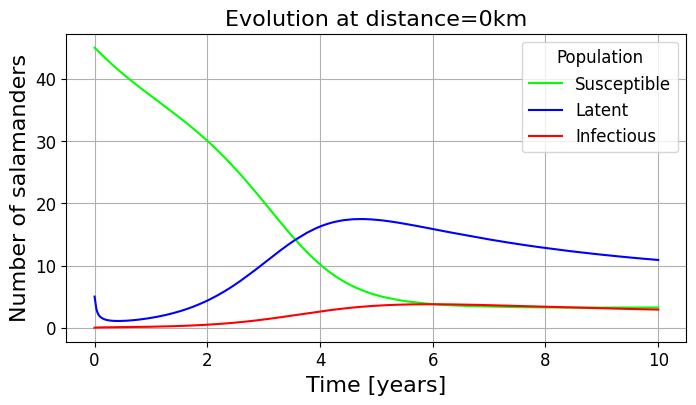

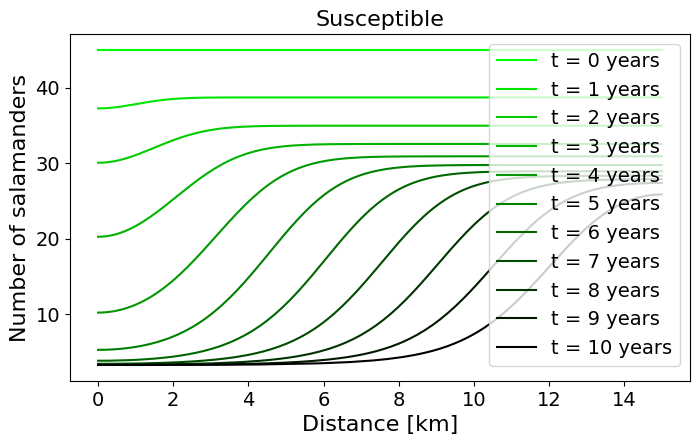

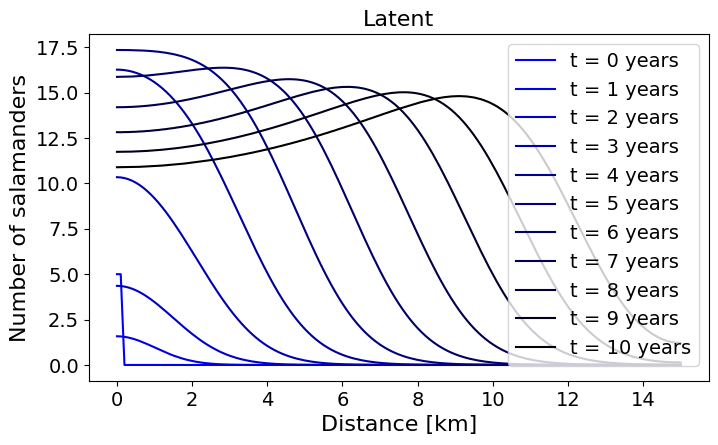

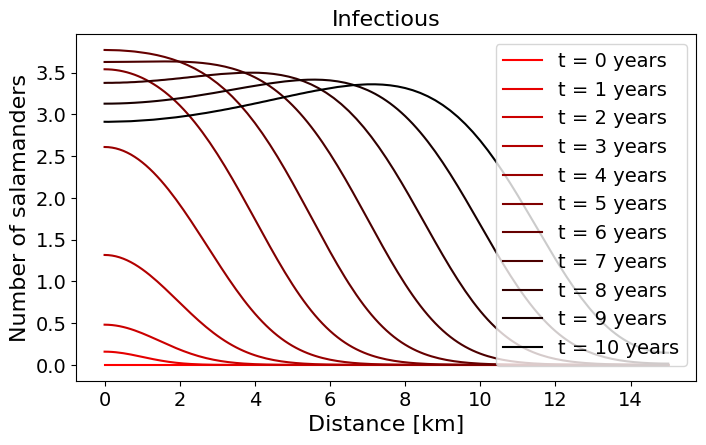

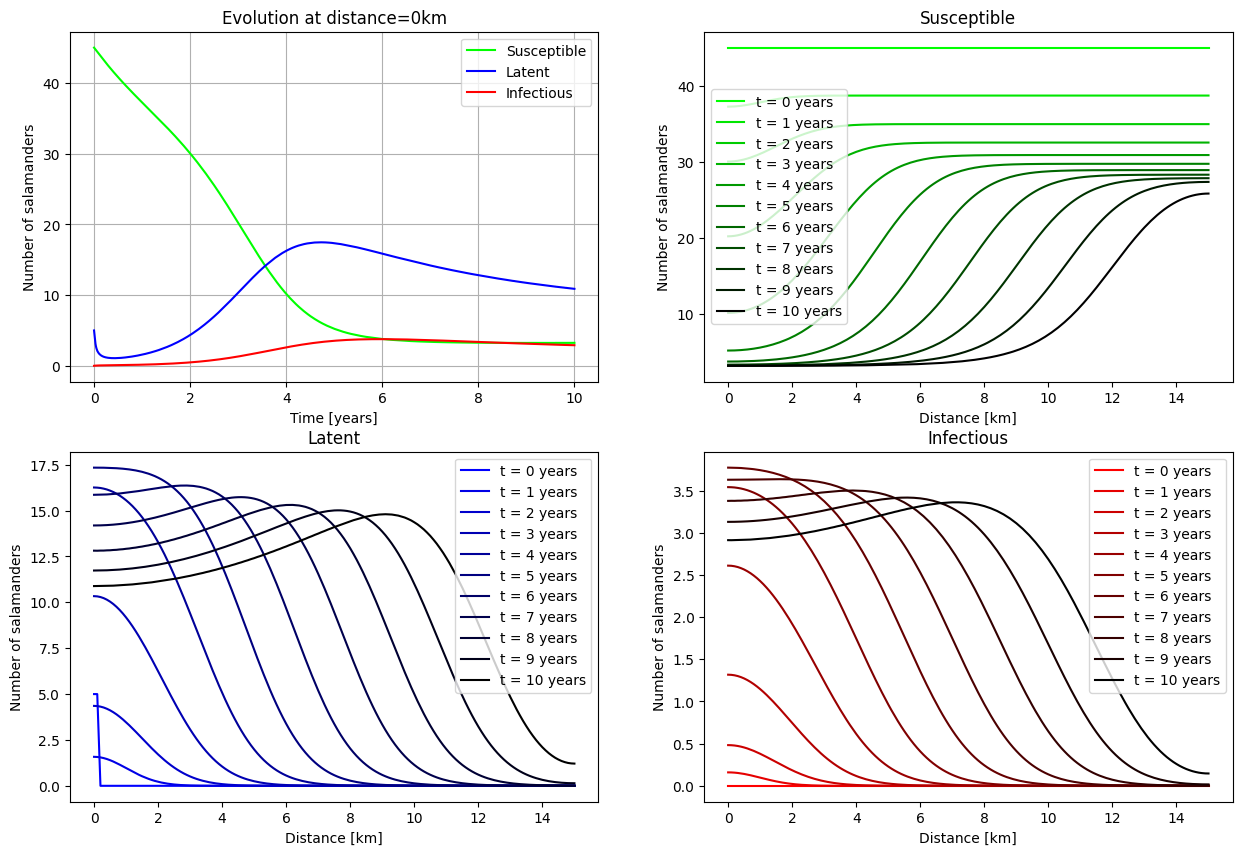

In [5]:
"""Flags"""
ENABLE_SPATIAL_DOMAIN_TERMS = True

"""
Spatial domain range (0, x_max), and grid size (h)
for the second order central diffence (FDM).
'delta_t' and 't' will be determined by the solver
"""
diffusion_rate = 0.5
delta_x = 0.1
max_x = 15
max_t = 10
if Decimal(str(max_x)) % Decimal(str(delta_x)) != 0:
    raise ValueError("max_x must be multiple of delta_x")
x = np.arange(0, max_x + delta_x, delta_x)
size_x = x.size
# Diffusion matrix
delta_h = np.eye(size_x, size_x, 0) * -2 \
            + np.eye(size_x, size_x, -1) \
            + np.eye(size_x, size_x, 1)
# Neumann BC
delta_h[0][1] = 2
delta_h[-1][-2] = 2
print(delta_h)

matrix_factor = (diffusion_rate / delta_x**2) * delta_h

"""Solver"""
max_delta_t = delta_x**2 / 2
max_delta_t = 1

"""Initial S: 45, L:5, I:0 for t0 = 0yrs and x0 = 0-10km"""
init_cond_during = 0.1 #km
data_points_for_init_cond = int(init_cond_during / delta_x) + 1

y0 = np.concatenate([
    np.array([45] * size_x),
    # np.array([45] * data_points_for_init_cond), np.array([0] * (size_x - data_points_for_init_cond)),
    np.array([5] * data_points_for_init_cond), np.array([0] * (size_x - data_points_for_init_cond)),
    np.array([0] * data_points_for_init_cond), np.array([0] * (size_x - data_points_for_init_cond)),
    ])

"""F parameters (check function 'sli_with_spatial_terms_model' docstring for an explanation)"""
b = 0.39
d = 0.125
B = 0.6
Y = 0.01
a = 0.9
e = 0.3

sol = solve_ivp(
    fun=sli_with_spatial_terms_model,
    t_span=[0, max_t],
    t_eval=np.linspace(0, max_t, 1001),
    y0=y0,
    args=(b, d, B, Y, a, e),
    max_step=max_delta_t
    )

save_plots(sol, x, size_x, max_t, suffix="_both_neumann")
plot_results(sol, x, size_x, max_t)

### Algorithm implementation (Dyrichlet BC on the left and Neumann BC on the right side)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  2. -2.]]


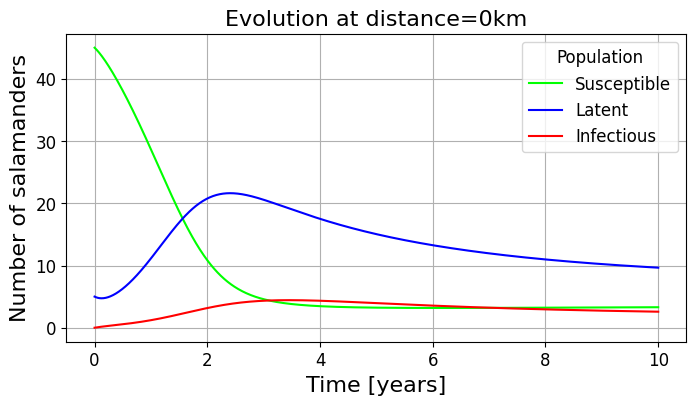

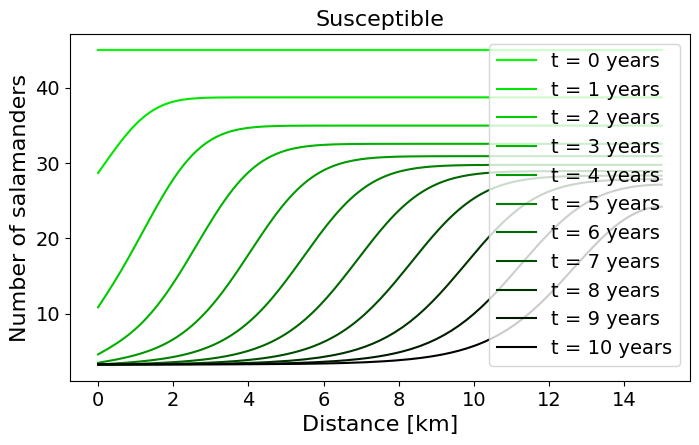

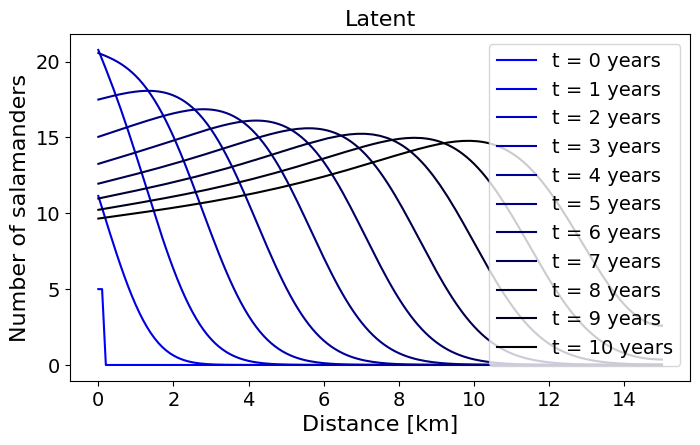

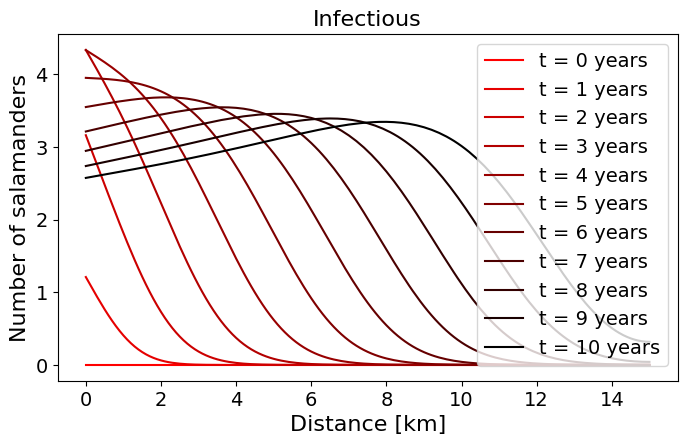

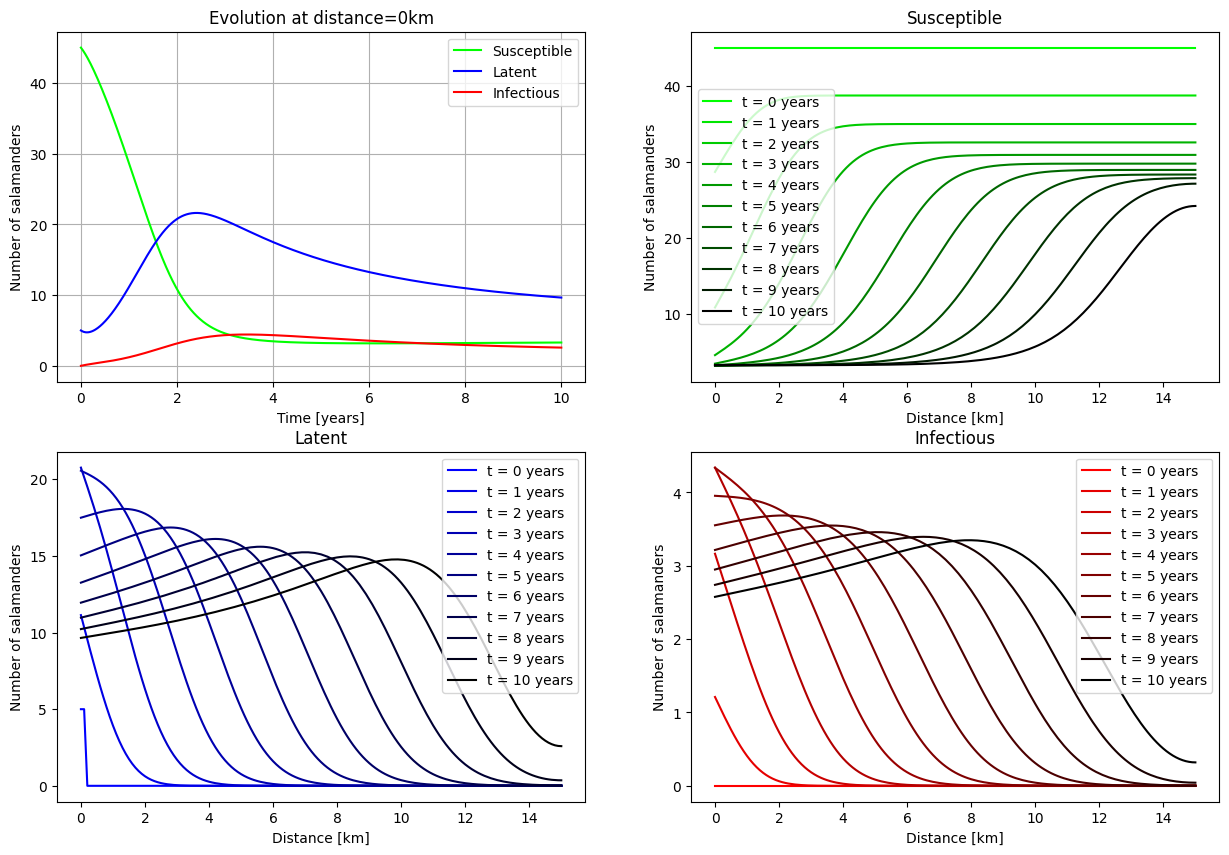

In [6]:
"""Flags"""
ENABLE_SPATIAL_DOMAIN_TERMS = True

"""
Spatial domain range (0, x_max), and grid size (h)
for the second order central diffence (FDM).
'delta_t' and 't' will be determined by the solver
"""
diffusion_rate = 0.5
delta_x = 0.1
max_x = 15
max_t = 10
if Decimal(str(max_x)) % Decimal(str(delta_x)) != 0:
    raise ValueError("max_x must be multiple of delta_x")
x = np.arange(0, max_x + delta_x, delta_x)
size_x = x.size
# Diffusion matrix
delta_h = np.eye(size_x, size_x, 0) * -2 \
            + np.eye(size_x, size_x, -1) \
            + np.eye(size_x, size_x, 1)
# Dyrichlet BC on the left side
delta_h[0][0] = 0
delta_h[0][1] = 0
# Neumann BC on the right side
delta_h[-1][-2] = 2
print(delta_h)

matrix_factor = (diffusion_rate / delta_x**2) * delta_h

"""Solver"""
max_delta_t = delta_x**2 / 2
max_delta_t = 1

"""Initial S: 45, L:5, I:0 for t0 = 0yrs and x0 = 0-10km"""
init_cond_during = 0.1 #km
data_points_for_init_cond = int(init_cond_during / delta_x) + 1

y0 = np.concatenate([
    np.array([45] * size_x),
    # np.array([45] * data_points_for_init_cond), np.array([0] * (size_x - data_points_for_init_cond)),
    np.array([5] * data_points_for_init_cond), np.array([0] * (size_x - data_points_for_init_cond)),
    np.array([0] * data_points_for_init_cond), np.array([0] * (size_x - data_points_for_init_cond)),
    ])

"""F parameters (check function 'sli_with_spatial_terms_model' docstring for an explanation)"""
b = 0.39
d = 0.125
B = 0.6
Y = 0.01
a = 0.9
e = 0.3

sol = solve_ivp(
    fun=sli_with_spatial_terms_model,
    t_span=[0, max_t],
    t_eval=np.linspace(0, max_t, 1001),
    y0=y0,
    args=(b, d, B, Y, a, e),
    max_step=max_delta_t
    )

save_plots(sol, x, size_x, max_t, suffix="_mixed")
plot_results(sol, x, size_x, max_t)

### Algorithm implementation (Dyrichlet BC on the left and Neumann BC on the right side), but a much higher diffusion rate

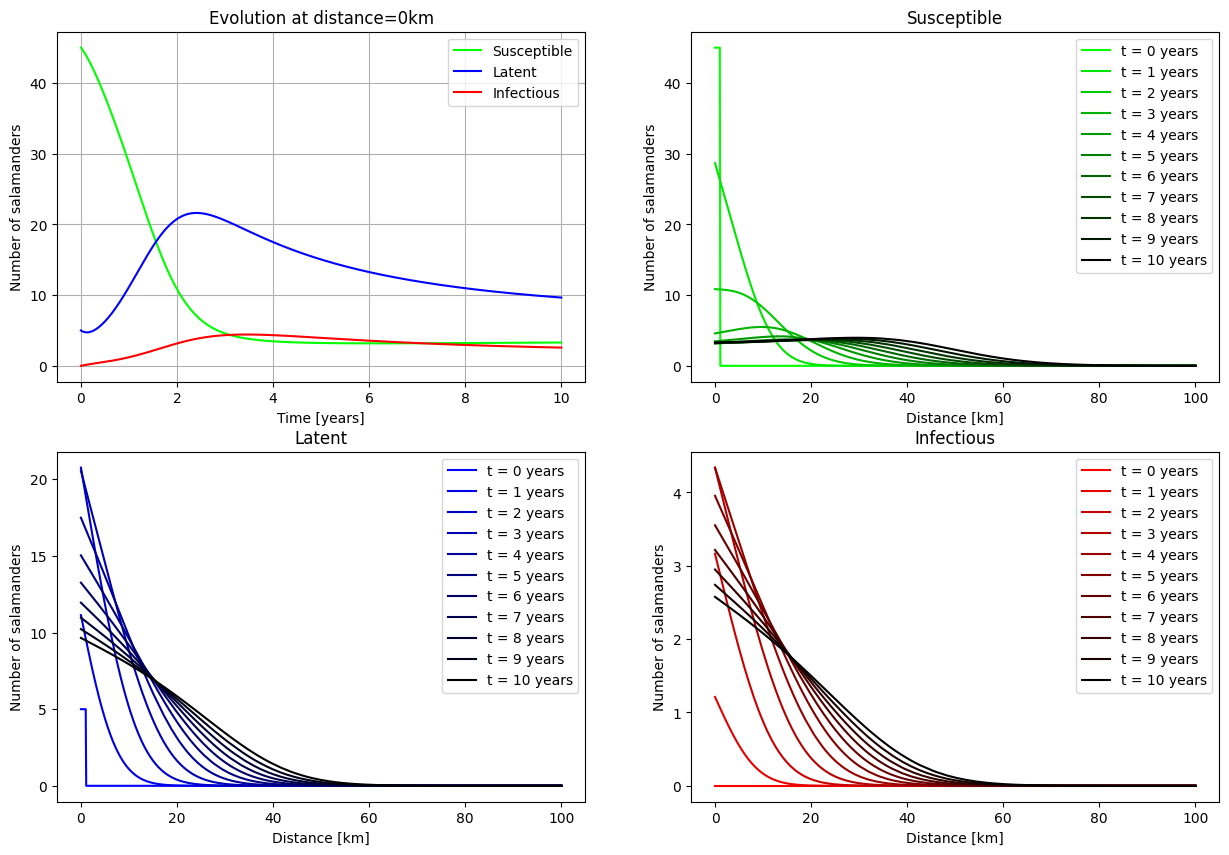

In [35]:
"""Flags"""
ENABLE_SPATIAL_DOMAIN_TERMS = True

"""
Spatial domain range (0, x_max), and grid size (h)
for the second order central diffence (FDM).
'delta_t' and 't' will be determined by the solver
"""
diffusion_rate = 25
delta_x = 0.1
max_x = 100
max_t = 10
if Decimal(str(max_x)) % Decimal(str(delta_x)) != 0:
    raise ValueError("max_x must be multiple of delta_x")
x = np.arange(0, max_x + delta_x, delta_x)
size_x = x.size
# Diffusion matrix
delta_h = np.eye(size_x, size_x, 0) * -2 \
            + np.eye(size_x, size_x, -1) \
            + np.eye(size_x, size_x, 1)
# Dyrichlet BC on the left side
delta_h[0][0] = 0
delta_h[0][1] = 0
# Neumann BC on the right side
delta_h[-1][-2] = 2

matrix_factor = (diffusion_rate / delta_x**2) * delta_h

"""Solver"""
max_delta_t = delta_x**2 / 2
max_delta_t = 1

"""Initial S: 45, L:5, I:0 for t0 = 0yrs and x0 = 0-10km"""
init_cond_during = 1 #km
data_points_for_init_cond = int(init_cond_during / delta_x) + 1

y0 = np.concatenate([
    np.array([45] * data_points_for_init_cond), np.array([0] * (size_x - data_points_for_init_cond)),
    np.array([5] * data_points_for_init_cond), np.array([0] * (size_x - data_points_for_init_cond)),
    np.array([0] * data_points_for_init_cond), np.array([0] * (size_x - data_points_for_init_cond)),
    ])

"""F parameters (check function 'sli_with_spatial_terms_model' docstring for an explanation)"""
b = 0.39
d = 0.125
B = 0.6
Y = 0.01
a = 0.9
e = 0.3

sol = solve_ivp(
    fun=sli_with_spatial_terms_model,
    t_span=[0, max_t],
    t_eval=np.linspace(0, max_t, 1001),
    y0=y0,
    args=(b, d, B, Y, a, e),
    max_step=max_delta_t
    )

plot_results(sol, x, size_x, max_t)

### Occurence of infection vs distance

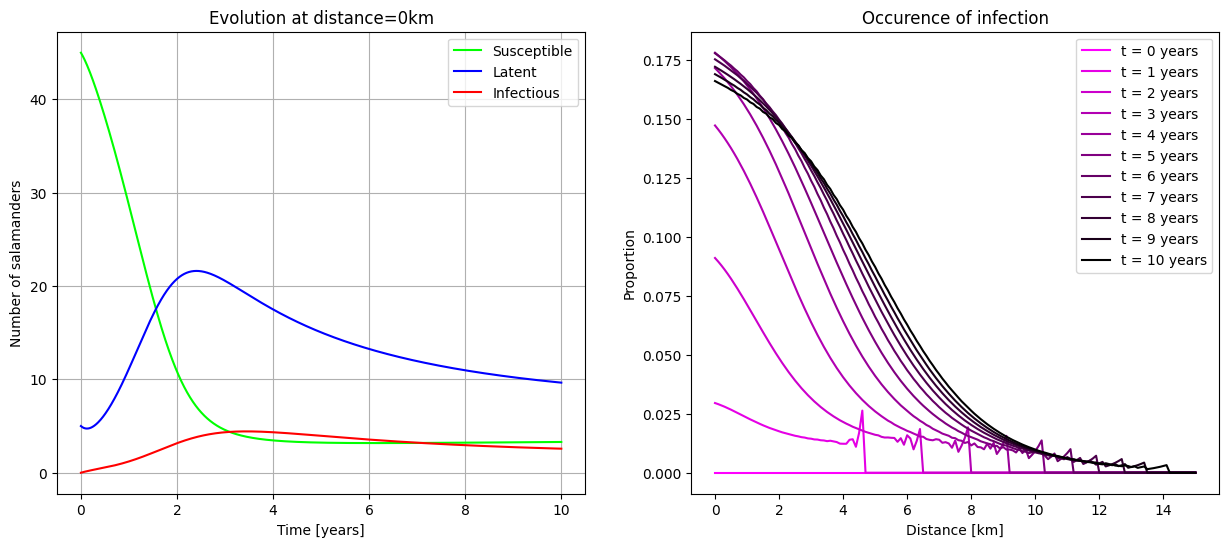

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

S, L, I = sol.y[:size_x,:], sol.y[size_x:2*size_x,:], sol.y[2*size_x:,:]

sns.lineplot(x=sol.t[:], y=S[0, :], label="Susceptible", ax=ax[0], color=[0, 1, 0])
sns.lineplot(x=sol.t[:], y=L[0, :], label="Latent", ax=ax[0], color=[0, 0, 1])
sns.lineplot(x=sol.t[:], y=I[0, :], label="Infectious", ax=ax[0], color=[1, 0, 0])

for year in range(max_t + 1):
    t_div_idx = int(year * (sol.t.size - 1) / (max_t))
    curr_year_S = np.round(S[:, t_div_idx], 5)
    curr_year_L = np.round(L[:, t_div_idx], 5)
    curr_year_I = np.round(I[:, t_div_idx], 5)
    curr_year_N = curr_year_S + curr_year_L + curr_year_I
    curr_year_occurrence_infection = np.divide(
        curr_year_I,
        curr_year_N,
        out=np.zeros_like(curr_year_I),
        where=(curr_year_N != 0)
        )
    sns.lineplot(x=x, y=curr_year_occurrence_infection,
        color=[np.linspace(1, 0, max_t + 1)[year], 0, np.linspace(1, 0, max_t + 1)[year]],
        label=f"t = {year} years",
        ax=ax[1])

ax[0].grid(True)
ax[0].set_title("Evolution at distance=0km")
ax[0].set_xlabel("Time [years]")
ax[0].set_ylabel("Number of salamanders")
ax[1].set_title("Occurence of infection")
ax[1].set_xlabel("Distance [km]")
ax[1].set_ylabel("Proportion")
plt.savefig("plots_presentation/diffused_sli_occurence_infection")
plt.show()